## **Applied Econometrics**

### **Assignment 5: Estimating the Savings Model**

#### *Conor Bayliss*

In this assignment, we are going to estimate the life-cycle savings model using indirect inference.

#### **Part 1**

*Re-use your code form last week's assignment to:*
1. *Load the PSID dataset from Arellano, Blundell and Bonhomme (2018)*
2. *Produce a *first stage estimate* of the income process parameters $(\mu,\rho,\sigma_{\eta})$*

*Recall that we already made a modelling assumption on the ages at which the life-cycle "begins" and "ends".*

Let us first reproduce the code from last time.

In [1]:
using CSV, DataFrames, DataFramesMeta, Statistics, Distributions, Random, LinearAlgebra, Plots, Optim, StatsBase
data = @chain begin
    CSV.read("C:\\Users\\bayle\\Documents\\Github\\metrics\\hw4\\data\\abb_aea_data.csv", DataFrame, missingstring="NA")
    @select :person :y :tot_assets1 :asset :age :year
end

@subset!(data, :age.>=25, :age.<=64)

Row,person,y,tot_assets1,asset,age,year
,Int64,Int64,Int64,Float64,Int64,Int64
1,17118,54000,60000,0.0,49,98
2,12630,61283,224000,39283.0,59,98
3,12647,42300,28240,0.0,38,98
4,5239,82275,7500,0.0,56,98
5,2671,69501,48000,3600.0,35,98
6,13027,68000,148000,20000.0,49,98
7,6791,93758,80000,160.0,41,98
8,6475,26581,23300,0.0,35,98
9,18332,33785,0,0.0,42,98


In [2]:
pars = (; T = 45, # length of a lifetime
            β = 0.95, # discount factor
            σ = 2.0, # risk aversion
            ρ = 0.9, # persistence of income
            ση = 0.1, # standard deviation of income shocks
            μ = fill(2., 45), # mean of log income (array of size 45 filled with 2.0)
            ψ = 5., # scaling factor in utility from bequest
            r = 0.05 # interest rate
)

(T = 45, β = 0.95, σ = 2.0, ρ = 0.9, ση = 0.1, μ = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ψ = 5.0, r = 0.05)

In [3]:
Φ(x) = cdf(Normal(), x)

function tauchen(ρ,ση,Kϵ)
    sd = ση/sqrt(1-ρ^2)
    grid = range(-3sd,stop=3sd,length=Kϵ)
    Π = zeros(Kϵ,Kϵ)
    Δ = grid[2]-grid[1]
    for j = 1:Kϵ
        Π[1,j] = Φ((grid[1]+Δ/2-ρ*grid[j])/ση)
        Π[end,j] = 1-Φ((grid[end]-Δ/2-ρ*grid[j])/ση)
        for k = 2:(Kϵ-1)
            Π[k,j] = Φ((grid[k]+Δ/2-ρ*grid[j])/ση) - Φ((grid[k]-Δ/2-ρ*grid[j])/ση)
        end
    end
    return Π, grid
end

Ka = 100
Kϵ = 5
agrid = LinRange(0, pars.μ[1]*pars.T, Ka)   # asset grid LinRange(start, stop, length)
Π, ϵgrid = tauchen(pars.ρ, pars.ση, Kϵ) # transition matrix and grid for epsilon
pars = (; pars..., Ka = Ka, agrid = agrid, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries

u(c,σ) = c^(1-σ)/(1-σ)

function solve_max(V,t,iϵ,ia,pars)
    (;agrid,ϵgrid,Π,σ,Ka,r,β) = pars
    cash = exp(pars.μ[t] + ϵgrid[iϵ]) + agrid[ia] # cash on hand in period t with state (iϵ,ia) (which is an input of the function)
    amax = 0
    vmax = -Inf
    a = 1
    loop = true
    while loop && a<Ka
        c = cash - agrid[a]/(1+r) # consumption in period t with state (iϵ,ia) and action a
        if c>0
            v = u(c,σ) # utility from consumption
            for iϵp in axes(V,1) # loop over possible values of iϵ in period t+1
                v += β*Π[iϵp,iϵ]*V[iϵp,a,t+1] # add continuation value to utility for each possible value of iϵ in period t+1
            end
            if v>vmax # if the utility is higher than the maximum utility found so far
                vmax = v # update the maximum utility
                amax = a # update the asset choice that corresponds to the maximum utility
            end
        else
            loop = false
        end
        a += 1
    end
    return amax, vmax
end

function iterate!(V,A,t,pars)
    for ia in axes(V,2), iϵ in axes(V,1)
        A[iϵ,ia,t], V[iϵ,ia,t] = solve_max(V,t,iϵ,ia,pars) # solve the maximization problem for each state (iϵ,ia) in period t
    end
end

function terminal_values!(V,pars)
    (;σ,ψ,agrid,T) = pars
    for ia in axes(V,2), iϵ in axes(V,1)
        # V[iϵ,ia] = ψ * u(agrid[ia],σ)
        V[iϵ,ia,T+1] = ψ * u(agrid[ia],σ) # alternative to the above (but make sure to change the backward_induction! function accordingly)
    end
end

function backward_induction!(V,A,pars)
    (;ψ,σ,T,agrid) = pars
    # @views terminal_values!(V[:,:,T+1],pars)
    @views terminal_values!(V,pars) # alternative to the above (but make sure to change the terminal_values! function accordingly)
    for t in reverse(1:T)
        iterate!(V,A,t,pars)
    end
end

V = zeros(pars.Kϵ,pars.Ka,pars.T+1)
A = zeros(Int64,pars.Kϵ,pars.Ka,pars.T)
backward_induction!(V,A,pars)
@time backward_induction!(V,A,pars)

  0.021171 seconds


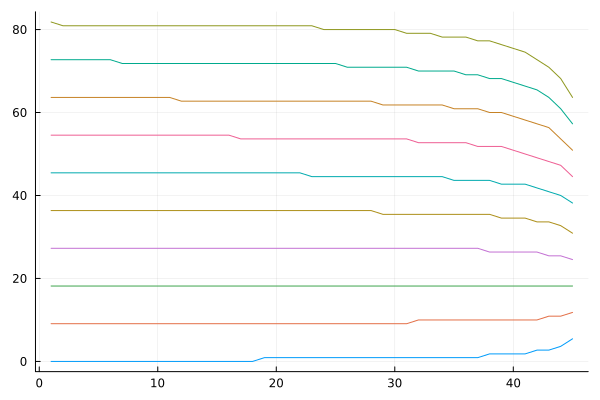

In [4]:
plot(1:pars.T,agrid[A[3,1:10:Ka,:]'],legend=false) # plot the asset policy function every 10 gridpoints for the median wage shock (iϵ=3) over time

In [5]:
df = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    combine(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
end

df2 = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    transform(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
    groupby(:age)
    transform([:log_y, :log_y_mean] => ByRow(-) => :resid) # calculate the residuals
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64
1,17118,54000,60000,0.0,49,98,10.8967,11.263,-0.366298
2,12630,61283,224000,39283.0,59,98,11.0233,11.2126,-0.189376
3,12647,42300,28240,0.0,38,98,10.6525,11.0695,-0.416965
4,5239,82275,7500,0.0,56,98,11.3178,11.219,0.0988382
5,2671,69501,48000,3600.0,35,98,11.1491,11.1646,-0.0155507
6,13027,68000,148000,20000.0,49,98,11.1273,11.263,-0.135774
7,6791,93758,80000,160.0,41,98,11.4485,11.1947,0.253742
8,6475,26581,23300,0.0,35,98,10.188,11.1646,-0.976695
9,18332,33785,0,0.0,42,98,10.4278,11.1441,-0.716335


In [6]:
function AR1_process(ρ,ση)
    var = ση^2/(1-ρ^2)
    cov_2 = ρ^2
    cov_4 = ρ^4
    return var, cov_2, cov_4
end

AR1_process (generic function with 1 method)

In [7]:
dlag1 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 2
    @rename :resid_lag1 = :resid
end

dlag2 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 4
    @rename :resid_lag2 = :resid
end

ylag1 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 2
    @rename :log_y_lag1 = :log_y
end

ylag2 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 4
    @rename :log_y_lag2 = :log_y
end

data = @chain df2 begin
    innerjoin(dlag1, on = [:person, :year])
    innerjoin(dlag2, on = [:person, :year])
    innerjoin(ylag1, on = [:person, :year])
    innerjoin(ylag2, on = [:person, :year])
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid,resid_lag1,resid_lag2,log_y_lag1,log_y_lag2
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,17118,43799,-2000,0.0,53,102,10.6874,11.3051,-0.617731,-0.433143,-0.366298,10.8532,10.8967
2,12630,68554,1519000,29454.0,63,102,11.1354,10.9559,0.179507,0.504693,-0.189376,11.5531,11.0233
3,12647,35000,78000,0.0,42,102,10.4631,11.1441,-0.681004,-0.799324,-0.416965,10.3255,10.6525
4,5239,49948,29900,0.0,60,102,10.8187,11.1392,-0.320425,-0.254721,0.0988382,10.9029,11.3178
5,2671,77000,84000,0.0,39,102,11.2516,11.1318,0.119767,0.129348,-0.0155507,11.2252,11.1491
6,13027,91000,248000,25000.0,53,102,11.4186,11.3051,0.113518,-0.453109,-0.135774,10.8332,11.1273
7,6791,122296,118650,154.0,45,102,11.7142,11.2052,0.509001,0.321919,0.253742,11.5179,11.4485
8,18332,54000,56000,0.0,46,102,10.8967,11.2661,-0.369324,-0.622871,-0.716335,10.6016,10.4278
9,3856,95800,357000,9600.0,37,102,11.47,11.0959,0.374122,0.0790909,-0.163537,11.2437,10.9205


In [8]:
estimates = @chain data begin
    @combine begin
        :v_resid = var(:resid)
        :c_resid_1 = cov(:resid, :resid_lag1)
        :c_resid_2 = cov(:resid, :resid_lag2)
    end
end

data_estimates = estimates.v_resid, estimates.c_resid_1, estimates.c_resid_2

([0.6042229503656219], [0.39374914076225126], [0.3537264122186027])

In [9]:
function ssd(ρ,ση,d)
    var, cov_2, cov_4 = AR1_process(ρ,ση)
    var_data, cov_2_data, cov_4_data = d
    return [(var.-var_data).^2, (cov_2.-cov_2_data).^2, (cov_4.-cov_4_data).^2]
end

function minimise(ρ,ση,d)
    weighted_ssd = ssd(ρ,ση,d)'*I*ssd(ρ,ση,d)
    return weighted_ssd
end

result = optimize(guess -> minimise(guess[1],guess[2],data_estimates), [pars.ρ,pars.ση], NelderMead())

out_ρ, out_ση = Optim.minimizer(result)

2-element Vector{Float64}:
 0.7062014705501509
 0.5511715773027391

In [10]:
v_first_stage, c1_first_stage, c2_first_stage = AR1_process(out_ρ, out_ση)

(0.6060294066149724, 0.49872051700719566, 0.24872215408392456)

Now, using the above code let us set up a new problem to solve. Note that I use the output of the above as my initial guesses for the AR1 process parameters, and below I back out the $\mu_t$ components. I also set the number of periods to $36$ since below we will find that the data runs from ages 29 to 64.

In [27]:
new_μ = [mean(data.log_y[data.age .== i]) for i in 29:64]

pars2 = (; T = 36, # length of a lifetime
            β = 0.95, # discount factor
            σ = 2.0, # risk aversion
            ρ = 0.7062138862462243, # persistence of income
            ση = 0.005, # standard deviation of income shocks
            μ = fill(2., 36), # mean of log income (array of size 45 filled with 2.0)
            ψ = 5., # scaling factor in utility from bequest
            r = 0.05, # interest rate
            R = 20, # number of simulations per simulate_individual
            N = 4000 # number of individuals
)

pars_new_μ = (; pars2..., μ = new_μ) 

Ka = 100
Kϵ = 5
agrid = LinRange(0, pars2.μ[1]*pars2.T, Ka)   # asset grid LinRange(start, stop, length)
agrid_μ = LinRange(0, 10000*pars_new_μ.μ[1]*pars_new_μ.T, Ka)   # asset grid LinRange(start, stop, length)
Π, ϵgrid = tauchen(pars2.ρ, pars2.ση, Kϵ) # transition matrix and grid for epsilon
pars2 = (; pars2..., Ka = Ka, agrid = agrid, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries
pars_new_μ = (; pars_new_μ..., Ka = Ka, agrid = agrid_μ, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries
@show pars_new_μ    

V = zeros(pars2.Kϵ,pars2.Ka,pars2.T+1)
A = zeros(Int64,pars2.Kϵ,pars2.Ka,pars2.T)
backward_induction!(V,A,pars2)
@time backward_induction!(V,A,pars2)

V_new_μ = zeros(pars_new_μ.Kϵ,pars_new_μ.Ka,pars_new_μ.T+1)
A_new_μ = zeros(Int64,pars_new_μ.Kϵ,pars_new_μ.Ka,pars_new_μ.T)
backward_induction!(V_new_μ,A_new_μ,pars_new_μ)
@time backward_induction!(V_new_μ,A_new_μ,pars_new_μ)

pars_new_μ = (T = 36, β = 0.95, σ = 2.0, ρ = 0.7062138862462243, ση = 0.005, μ = [10.993812474723722, 11.078335522797012, 11.158777878094064, 11.112767994493877, 11.2209004827313, 11.13083427177491, 11.281243754154762, 11.182396927933192, 11.268005735941397, 11.226586501591653, 11.345641463323645, 11.196507872138021, 11.275632277983238, 11.285727731096799, 11.314041795913205, 11.305578365235602, 11.312824518942529, 11.309126464013803, 11.27213790838133, 11.369749181356914, 11.289083091969069, 11.379124636624745, 11.307150089498414, 11.400826809079122, 11.33948294881408, 11.359604344132613, 11.34566705136605, 11.326835382609008, 11.299304462604056, 11.279649784604441, 11.255043281855107, 11.186201156915338, 11.09079378135074, 11.200516567901545, 11.0075450908281, 11.089667926456038], ψ = 5.0, r = 0.05, R = 20, N = 4000, Ka = 100, agrid = LinRange{Float64}(0.0, 3.95777249090054e6, 100), Π = [0.42640480938044223 0.04630830654657571 0.0007415438032500226 1.4755691075486073e-6 3.40564697018

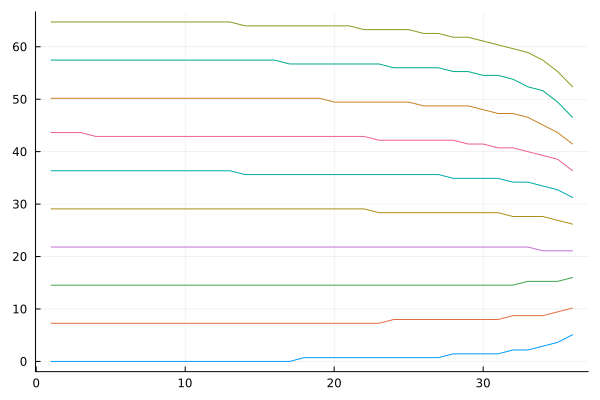

In [28]:
plot(1:pars2.T,agrid[A[3,1:10:Ka,:]'],legend=false) # plot the asset policy function every 10 gridpoints for the median wage shock (iϵ=3) over time

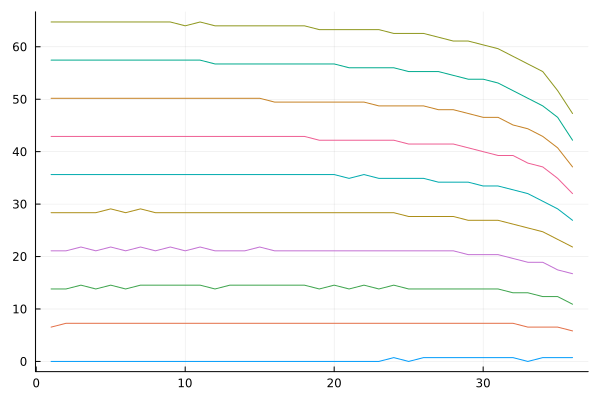

In [29]:
plot(1:pars_new_μ.T,agrid[A_new_μ[3,1:10:Ka,:]'],legend=false)

#### **Part 2**

*Describe which statistics you are going to try to match using the model. Write a function that takes that dataset and calculates these statistics.*

I will try to match the variance of log income at every age of the panel above. The code below collects these moments from the data.

In [14]:
grouped_data = @chain data begin
    groupby(:age)
    combine(:log_y => var => :var_log_y)
end

var_log_y_vector = zeros(3)
var_log_y_vector = grouped_data.var_log_y[1], grouped_data.var_log_y[10], grouped_data.var_log_y[20]

(0.5770594028849826, 0.3779718435255362, 0.9566472952144013)

In [15]:
log_y_mean_35 = data[data.age .== 35, :log_y_mean][1]
log_y_mean_45 = data[data.age .== 45, :log_y_mean][1]
log_y_mean_55 = data[data.age .== 55, :log_y_mean][1]

@show log_y_mean_35, log_y_mean_45, log_y_mean_55

means = [log_y_mean_35, log_y_mean_45, log_y_mean_55]

(log_y_mean_35, log_y_mean_45, log_y_mean_55) = (11.16464708581355, 11.205198367199255, 11.289951332574208)


3-element Vector{Float64}:
 11.16464708581355
 11.205198367199255
 11.289951332574208

#### **Part 3**

*Write a function that:*
1. *Solves for the optimal savings policies given the estimates $(\hat{\mu}, \hat{\rho},\hat{\sigma}_{\eta})$ and given a guess of the parameters $\beta$ and $\sigma$.*
2. *Simulates a panel dataset of income and savings outcomes $(y_{n,r,t}, a_{n,r,t})_{n=1,r=1,t=1}^{N,R,T}$. That is, simulate an $N$ x $T$ panel $R$ times. Note that you will have to make an assumption on initial conditions for assets.*
3. *Calculates the same statistics from the simulated data as you have calculated from the real data.*

In [16]:
function solve_model(p)
    (; T, Ka, Kϵ) = p
    V = zeros(Kϵ,Ka,T+1)
    A = zeros(Int64,Kϵ,Ka,T)
    backward_induction!(V,A,p)
    return V, A
end

test_V, test_A = solve_model(pars_new_μ)
@show test_A

test_A = [1 2 3 4 5 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99; 1 2 3 4 5 6 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99; 1 2 3 4 5 6 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99; 1 2 3 4 5 6 7 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

5×100×36 Array{Int64, 3}:
[:, :, 1] =
 1  2  3  4  5  5  6  7  8  9  10  11  …  91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  6  7  8  9  10  11     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  6  7  8  9  10  11     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  7  8  9  10  11     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  7  8  9  10  11     91  92  93  94  95  96  97  98  99

[:, :, 2] =
 1  2  3  4  5  6  7  8  9  10  11  12  …  91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  8  9  10  11  12     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  8  9  10  11  12     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  8  9  10  11  12     91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  8  9  10  11  12     91  92  93  94  95  96  97  98  99

[:, :, 3] =
 1  2  3  4  5  6  7  8  9  10  11  12  …  91  92  93  94  95  96  97  98  99
 1  2  3  4  5  6  7  8  9  10  11  12     91  92  93  94  95  96  97  98  99
 1  2

In [30]:
function simulate_individual(p,V,A)
    (; T, β, σ, ρ, ση, μ, ψ, r, Ka, agrid, Π, ϵgrid, Kϵ, R) = p
    sim_ind_a = zeros(R,T)
    sim_ind_ϵ = zeros(R,T)
    cash = zeros(R,T)
    for r in 1:R
        for t in 1:T
            if t == 1
                sim_ind_ϵ[r,t] = rand(1:Kϵ)
                sim_ind_a[r,t] = rand(1:Ka)
            else
                sim_ind_ϵ[r,t] = sample(1:Kϵ, Weights(Π[Int(sim_ind_ϵ[r,t-1]),:]))
                if sim_ind_a[r,t-1] == 0
                    sim_ind_a[r,t] = A[Int(sim_ind_ϵ[r,t]),1,t]
                else
                    sim_ind_a[r,t] = A[Int(sim_ind_ϵ[r,t]),Int(sim_ind_a[r,t-1]),t]
                end
            end
            cash[r,t] = exp(p.μ[t] + sim_ind_ϵ[r,t]) + sim_ind_a[r,t]
        end
    end
    cash .= log.(cash)
    return sim_ind_a, sim_ind_ϵ, cash
end

a, ϵ, c = simulate_individual(pars_new_μ,test_V,test_A)
@show c

c = [13.993823351631638 15.078339199890232 14.158787100882506 14.112777651533001 15.220903671254423 14.130843755914643 16.281244858459132 16.18239814697162 16.268006854961754 16.226587667934208 16.34564249875482 16.196509074095477 16.275633388501802 16.285728830460585 16.314042864586092 16.305579442991508 16.312825588917075 16.309127537952495 16.272139022787247 16.369750192124705 15.289086070336577 15.379127358534957 14.307158040563163 13.400846489480097 12.33953982908374 12.359660091361194 13.345687847819518 12.326892986823344 12.299363674700132 13.279672000299483 12.255100412768485 13.186221796160208 13.090814422601735 13.200533214572337 13.007563037380605 12.089707246449166; 15.99382175983972 16.07834395130675 16.158785559138053 16.11277593666314 16.220907520670384 16.130841874280733 16.281250210070738 16.18240396082678 16.26801210573285 16.226593051036062 16.34564719800591 16.196514436657303 16.275638257684033 16.285733566167682 15.314056990950332 15.305593464065682 16.312829868803

20×36 Matrix{Float64}:
 13.9938  15.0783  14.1588  14.1128  …  13.0908  13.2005  13.0076  12.0897
 15.9938  16.0783  16.1588  16.1128     16.0908  16.2005  16.0075  16.0897
 13.9939  15.0783  15.1588  15.1128     16.0908  16.2005  16.0075  16.0897
 11.9939  12.0784  12.1588  12.1128     16.0908  16.2005  16.0075  15.0897
 11.9942  12.0787  12.1591  12.1131     16.0908  16.2005  16.0075  16.0897
 12.9939  12.0786  12.159   13.1129  …  16.0908  16.2005  16.0075  16.0897
 15.9938  16.0783  16.1588  16.1128     16.0908  16.2005  16.0075  16.0897
 13.9939  16.0783  16.1588  16.1128     16.0908  16.2005  16.0075  16.0897
 15.9938  16.0783  16.1588  16.1128     16.0908  16.2005  16.0075  16.0897
 14.9938  15.0784  15.1588  16.1128     12.091   12.2006  12.0077  12.0898
 13.9939  14.0784  14.1588  14.1128  …  12.0909  12.2006  12.0077  12.0897
 11.9939  12.0784  12.1588  12.1128     12.0908  13.2005  13.0076  12.0897
 12.994   12.0787  13.1589  12.1131     12.0909  12.2006  12.0076  12.0897
 1

In [31]:
function simulate_data(p,V,A)
    (; T, β, σ, ρ, ση, μ, ψ, r, Ka, agrid, Π, ϵgrid, Kϵ, R, N) = p
    sim_data_a = zeros(R,T,N)
    sim_data_ϵ = zeros(R,T,N)
    sim_data_c = zeros(R,T,N)
    for n in 1:N
        sim_data_a[:,:,n], sim_data_ϵ[:,:,n], sim_data_c[:,:,n] = simulate_individual(p,V,A)
    end
    return sim_data_a, sim_data_ϵ, sim_data_c
end

a_μ, ϵ_μ, c_μ = simulate_data(pars_new_μ,test_V,test_A)
a2, ϵ2, c2 = simulate_data(pars2,V,A)

([42.0 42.0 … 30.0 29.0; 2.0 2.0 … 19.0 21.0; … ; 14.0 14.0 … 23.0 24.0; 74.0 73.0 … 33.0 31.0;;; 70.0 69.0 … 33.0 31.0; 48.0 48.0 … 30.0 29.0; … ; 37.0 37.0 … 29.0 28.0; 13.0 13.0 … 22.0 23.0;;; 60.0 60.0 … 33.0 31.0; 100.0 99.0 … 37.0 34.0; … ; 51.0 51.0 … 31.0 30.0; 74.0 74.0 … 34.0 32.0;;; … ;;; 16.0 16.0 … 24.0 25.0; 66.0 66.0 … 33.0 31.0; … ; 42.0 42.0 … 30.0 29.0; 33.0 33.0 … 29.0 28.0;;; 45.0 44.0 … 27.0 27.0; 97.0 96.0 … 37.0 34.0; … ; 80.0 79.0 … 34.0 32.0; 32.0 31.0 … 27.0 27.0;;; 58.0 57.0 … 27.0 27.0; 99.0 98.0 … 39.0 36.0; … ; 33.0 33.0 … 29.0 28.0; 16.0 16.0 … 23.0 24.0], [5.0 4.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 4.0 5.0 … 3.0 2.0; 2.0 2.0 … 1.0 1.0;;; 3.0 4.0 … 1.0 1.0; 3.0 3.0 … 5.0 5.0; … ; 4.0 4.0 … 4.0 5.0; 3.0 3.0 … 1.0 2.0;;; 5.0 5.0 … 5.0 5.0; 1.0 1.0 … 2.0 2.0; … ; 2.0 3.0 … 4.0 4.0; 5.0 5.0 … 2.0 1.0;;; … ;;; 2.0 3.0 … 5.0 5.0; 5.0 4.0 … 5.0 5.0; … ; 3.0 4.0 … 5.0 5.0; 5.0 5.0 … 5.0 5.0;;; 2.0 1.0 … 1.0 1.0; 3.0 2.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 

In [32]:
function calculate_moments(p,a,ϵ,c)
    (; T, β, σ, ρ, ση, μ, ψ, r, Ka, agrid, Π, ϵgrid, Kϵ, R, N) = p
    moments = zeros(T)
    for t in 1:T
        moments[t] = var(c[:,t,:])
    end
    out_moments = [moments[1], moments[10], moments[20]]
    return out_moments
end

m = calculate_moments(pars_new_μ,a,ϵ,c)

function new_calculate_moments(p,a,ϵ,c)
    (; T, β, σ, ρ, ση, μ, ψ, r, Ka, agrid, Π, ϵgrid, Kϵ, R, N) = p
    moments = zeros(3)
    moments[1] = mean(c[:,15,:])
    moments[2] = mean(c[:,25,:])
    moments[3] = mean(c[:,35,:])
    return moments
end

m_μ = new_calculate_moments(pars_new_μ, a_μ, ϵ_μ, c_μ)
@show m_μ
new_m = new_calculate_moments(pars2, a2, ϵ2, c2)

m_μ = [14.321858139764707, 14.34640383560544, 14.013993637441029]


3-element Vector{Float64}:
 5.489423818335441
 5.443793476612724
 5.405277867734276

#### **Part 4**

*Write a function that calculates an indirect inference estimate by minimising the difference between the model's implied statistics and those in the data.*

In [33]:
function min(d,guess_ρ,guess_ση,p)
    new_params = (; p..., ρ=guess_ρ, ση=guess_ση)  # create a new NamedTuple with the updated values
    test_V, test_A = solve_model(new_params)
    a, ϵ, c = simulate_data(new_params,test_V,test_A)
    moments = new_calculate_moments(new_params,a,ϵ,c)
    #moments = calculate_moments(new_params,a,ϵ,c)
    return (moments.-d).^2
end

function obj(d,guess,p)
    return min(d,guess[1],guess[2],p)'*I*min(d,guess[1],guess[2],p)
end

result = optimize(guess -> obj(means,guess,pars_new_μ), [0.75,0.001], NelderMead(), Optim.Options(show_trace=true))
#result = optimize(guess -> obj(var_log_y_vector,guess,pars2), [0.75,0.1], NelderMead(), Optim.Options(show_trace=true))#

out_ρ, out_ση = Optim.minimizer(result)

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.493501e+02     6.655613e-01
 * time: 0.017999887466430664
     1     2.493501e+02     1.035081e+00
 * time: 2.7300000190734863
     2     2.472474e+02     9.462114e-01
 * time: 3.6499998569488525
     3     2.472474e+02     8.444949e-01
 * time: 4.7769999504089355
     4     2.472474e+02     1.683687e+00
 * time: 8.555999994277954
     5     2.472474e+02     1.528590e+00
 * time: 12.35699987411499
     6     2.472474e+02     1.402240e+00
 * time: 16.105000019073486
     7     2.466504e+02     1.234560e+00
 * time: 17.986999988555908
     8     2.466504e+02     1.993317e+00
 * time: 21.86899995803833
     9     2.466504e+02     8.594668e-01
 * time: 23.804999828338623
    10     2.466504e+02     7.403170e-01
 * time: 25.609999895095825
    11     2.466504e+02     5.486697e-01
 * time: 27.500999927520752
    12     2.466504e+02     1.544498e+00
 * time: 31.198999881744385
    13     2.466504